In [1]:
%matplotlib inline
import xlrd
import operator
import math
import re
import nltk
import scipy
import random
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
from pactools.grid_search import GridSearchCVProgressBar
from collections import Counter, defaultdict
from itertools import chain, product
from decimal import Decimal
from ast import literal_eval
from tqdm import tqdm

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

pd.options.mode.chained_assignment = None

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stemmer = nltk.stem.snowball.SnowballStemmer("dutch")

In [2]:
# Importing data
def importdata(file):
    df = pd.read_csv(file, index_col=0)
    df = df.loc[df['speech category'] == 'Main Speech']
    return df 
df = importdata("HandelingenRutte2.csv")
df['stemmed_text'] = df.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
df['normal_text'] = df.text.apply(lambda x: ' '.join([t.lower() for t in tokenizer.tokenize(x)]))
df.drop(columns=['tags'])
df.head(5)

,surname,party,text,file,speech category,date,tags,titel,stemmed_text,normal_text
175881,Wilders,PVV,\r\n \r\n Mevrouw de voo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,mevrouw de voorzitter dit kabinet heeft ons mo...,mevrouw de voorzitter dit kabinet heeft ons mo...
175882,Roemer,SP,\r\n \r\n Voorzitter. Vo...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter vorig wek plaatst werkgever werknem...,voorzitter vorige week plaatsten werkgevers we...
175883,Pechtold,D66,\r\n \r\n Voorzitter. Tw...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter twee maand geled kreg dit kabinet v...,voorzitter twee maanden geleden kreeg dit kabi...
175884,Van Haersma Buma,CDA,\r\n \r\n Voorzitter. Al...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter allen al in de eerst drie maand van...,voorzitter alleen al in de eerste drie maanden...
175889,Thieme,PvdD,\r\n \r\n Voorzitter. We...,h-tk-20122013-100-3.xml,Main Speech,2013-06-26,"['Bestuur | Parlement', 'Financiën | Begroting']",Aanbevelingen Europese Commissie extra bezuini...,voorzitter we zijn eruit eerst ontdekt de mini...,voorzitter we zijn eruit eerst ontdekte de min...


# Data Info

803.9600230083405 444.0


c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


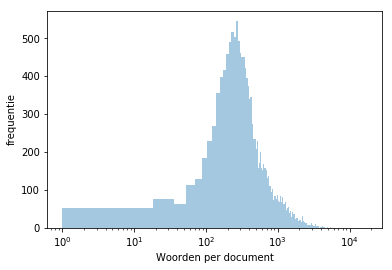

In [3]:
#leaving out all that is outside 95%
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
t = [len(doc) for doc in list_text]
print(np.mean(t),np.median(t))
fit =scipy.stats.lognorm.fit(t)
ax = sns.distplot(t,bins=1000,norm_hist=False,kde=False)
ax.set_xscale('log')
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtextslog.png")

c:\users\m6800\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


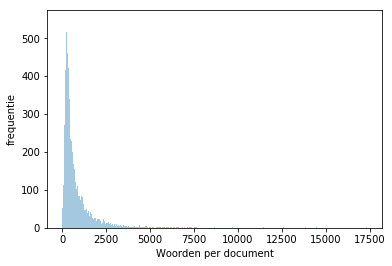

In [4]:
ax = sns.distplot(t, bins=1000, norm_hist=False,kde=False)
ax.set(xlabel='Woorden per document', ylabel='frequentie')
plt.savefig("Verslag/Tables/lengthtexts.png")

In [5]:
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
df = df.loc[df.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]
list_text = df.stemmed_text.apply(lambda x: x.split(" "))
print("Ondergrens:",math.exp(fit[0]+2*fit[1]),"\nBovengrens:",math.exp(fit[0]-2*fit[1]))
print("Mediaan",np.median([len(doc) for doc in list_text]),"\nGemiddelde",np.mean([len(doc) for doc in list_text]))
print("Overgebleven documenten:",len(df))

Ondergrens: 1492.675589876518 
Bovengrens: 27.339307082607387
Mediaan 386.0 
Gemiddelde 498.18961004094234
Overgebleven documenten: 14899


In [6]:
len(df.file.unique())

2984

In [7]:
#https://stackoverflow.com/questions/11350770/pandas-dataframe-select-by-partial-string

# Creates a dataframe with counts of dataset per party
countdf = pd.concat([df.party.value_counts(),df[df['titel'].str.contains("Vragen van het lid")].party.value_counts(), df[~df['titel'].str.contains("Vragen van het lid")].party.value_counts()], axis=1)
countdf.columns = ['Totaal', 'Vragenuur','Debat']
countdf = countdf.sort_values("Totaal",axis=0, ascending=False)
with open("Verslag/Tables/Spreekbeurten.tex", "w") as f:
    f.write(countdf.to_latex(header=True))
countdf = countdf.sort_index()
countdf

,Totaal,Vragenuur,Debat
50PLUS,387,12,375
CDA,1901,88,1813
ChristenUnie,1068,32,1036
D66,1889,133,1756
GroenLinks,1068,47,1021
PVV,1700,49,1651
PvdA,1821,112,1709
PvdD,432,14,418
SGP,655,10,645
SP,2284,107,2177


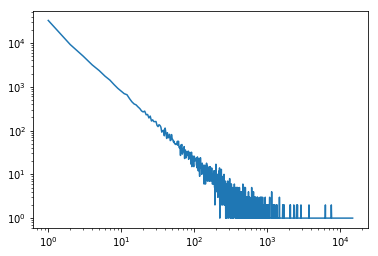

In [8]:
tekst = chain.from_iterable([list(set(doc)) for doc in list_text])
del list_text
count = Counter(tekst)
samples = list(count.values())
t = Counter(samples)
t = sorted(t.items())
x, y = zip(*t)
plt.loglog(x, y)
plt.show()

# Baseline

In [9]:
simpleprediction = np.random.choice(countdf.index, len(df.party), p = [x/countdf["Totaal"].sum() for x in list(countdf['Totaal'])])
print(classification_report(df.party, simpleprediction))
print("Accuracy:",accuracy_score(df.party, np.full(len(df.party), countdf["Totaal"].idxmax())))

              precision    recall  f1-score   support

      50PLUS       0.03      0.03      0.03       387
         CDA       0.13      0.13      0.13      1901
ChristenUnie       0.07      0.07      0.07      1068
         D66       0.12      0.12      0.12      1889
  GroenLinks       0.07      0.07      0.07      1068
         PVV       0.11      0.11      0.11      1700
        PvdA       0.12      0.12      0.12      1821
        PvdD       0.04      0.04      0.04       432
         SGP       0.05      0.05      0.05       655
          SP       0.15      0.14      0.15      2284
         VVD       0.12      0.13      0.12      1694

 avg / total       0.11      0.11      0.11     14899

Accuracy: 0.15329887911940399


# Models

In [10]:
def modelsdownload(file,only_doen=False):
    models_df = pd.read_excel(file, index_col=0)
    if only_doen:
        models_df = models_df.loc[models_df.DOEN == True]
    models_dict = {}
    for x,y in zip(models_df.Classifier, models_df.PIPELINE):
        exec(compile("a="+y,'','exec'), globals())
        models_dict[x] = Pipeline(a)
    return models_df, models_dict

In [ ]:
models_df, models_dict = modelsdownload('Models.xlsx',True)

# Creates a dict with parameters per classifier   
params_dict = {}
for clf in set(models_df.Classifier):
    params_df = models_df.loc[models_df.Classifier == clf]
    params_df = params_df.loc[params_df.DOEN == True]
    params_df = params_df.dropna(axis=1, how='all')
    params_df = params_df.drop([col for col in params_df.columns if "__" not in col], axis=1)
    temp_dict = {}
    for x, y in params_df.to_dict(orient='list').items():
        a = literal_eval(y[0])
        temp_dict[x] = a
    params_dict[clf] = temp_dict
    
text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}


In [ ]:
scoring = ['accuracy', 'f1_weighted', 'precision_weighted','recall_weighted']
for name, pipe in models_dict.items():
    print("Bezig: %s" %name)
    text = df.stemmed_text if text_dict[name] else df.normal_text
        
    gs = GridSearchCVProgressBar(pipe, params_dict[name], cv=5, scoring=scoring, refit = False, return_train_score = False, n_jobs=-1)
    gs.fit(text, df.party)
    rows = pd.DataFrame(gs.cv_results_)
    # https://stackoverflow.com/questions/38231591/splitting-dictionary-list-inside-a-pandas-column-into-separate-columns
    rows = pd.concat([rows.drop(['params'], axis=1), rows['params'].apply(pd.Series)], axis=1)
    rows["name"] = name 
    rows["stemmed"] = text_dict[name]
    pd.concat([rows, pd.read_excel('Scores.xlsx', index_col=0)], ignore_index=True).sort_values(['mean_test_f1_weighted'], ascending=False).to_excel('Scores.xlsx')
    df4 = pd.read_excel('Models.xlsx', index_col=0)
    df4.loc[df4.Classifier == name, "DOEN"] = False
    df4.to_excel('Models.xlsx')
    print("Voltooid: %s" %name)
    
# https://stackoverflow.com/questions/46735847/save-best-params-in-gridsearch-in-a-pandas-dataframe
# https://stackoverflow.com/questions/36271413/pandas-merge-nearly-duplicate-rows-based-on-column-value?rq=1

# Best Score

In [11]:
#source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Echte klasse')
    plt.xlabel('Voorspelde klasse')

In [43]:
# https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
def classification_report_csv(real,predicted):
    report = classification_report(real, predicted)
    report_data = []
    lines = report.split('\n')
    for line in lines[0:-1]:
        row = {}
        row_data = line.split('     ')
        if len(row_data)<5:
            continue
        row['Partij'] = row_data[-5].replace(" ","")
        row['Precision'] = float(row_data[-4])
        row['Recall'] = float(row_data[-3])
        row['F1 score'] = float(row_data[-2])
        if row['Partij']!='avg/total':
            row['Accuracy'] = np.nan
        else:
            row['Accuracy'] = accuracy_score(real, predicted)
        row['Documenten'] = int(row_data[-1])
        report_data.append(row)
    df = pd.DataFrame.from_dict(report_data)
    df = df.reindex(["Partij","Precision","Recall",'F1 score',"Accuracy","Documenten"], axis=1).set_index('Partij')
    as_list = df.index.tolist()
    idx = as_list.index('avg/total')
    as_list[idx] = 'Totaal'
    df.index = as_list
    return df

In [13]:
# Select the classifier and parameters with highest score
def getbestpipe(file):
    scores = pd.read_excel(file, index_col=0).sort_values(['mean_test_f1_weighted'], ascending=False).head(1)
    scores = scores.dropna(axis=1).reset_index(drop=True)
    scores.vect__ngram_range[0] = literal_eval(scores.vect__ngram_range[0])
    models_df, models_dict = modelsdownload('Models.xlsx',False)
    text_dict = {x:y for x, y in zip(models_df.Classifier, models_df.STEMMED)}
    pipe = models_dict[scores.name[0]]
    params = scores.drop([col for col in scores.columns if "__" not in col or "param" in col], axis=1).to_dict(orient='records')[0]
    params['vect__min_df'] = int(params['vect__min_df'])
    pipe.set_params(**params)
    stem = text_dict[scores.name[0]]
    return pipe, stem

In [ ]:
def traintest3(pipe, text, data, save=False):
    train, test = train_test_split(data, test_size=0.2)
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return [pipe, cnf_matrix, report, accuracy, indices]
    

def traintest(file, data, save=False, params=None, stemmed="stemmed_text",normal="normal_text"):
    n=5
    base_pipe, stem = getbestpipe(file)
    if params!=None:
        base_pipe.set_params(**params)
    text = stemmed if stem else normal
    pipelist, cnflist, reportlist, accuracylist, indiceslist = zip(*[traintest3(base_pipe, text, data, save=False) for x in tqdm(range(n))])
    accuracy = np.mean(accuracylist)
    cnf_matrix = np.mean(cnflist, axis=0)
    #https://stackoverflow.com/questions/45983321/sum-a-list-of-pandas-dataframes?rq=1
    report = reduce(lambda x, y: x.add(y, fill_value=0), reportlist) /n 
    report=report.round(2).fillna('-')
    report.Documenten = report.Documenten.round(0).astype(int)
    print(report)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(data.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())

    plt.show()
    return pipelist[0], indiceslist

In [15]:
def mostimportantwords(pipe, countdf, filename=None):
    vocab = pipe.named_steps['vect'].vocabulary_
    inv_vocab = {v: k for k, v in vocab.items()}
    coefs = pipe.named_steps[[x for x in pipe.named_steps.keys() if not x=='vect'][0]].coef_
    top_words = [[inv_vocab[t] for t in coefs[i].argsort()[-100:][::-1]] for i in range(coefs.shape[0])]
    top_words = pd.DataFrame(top_words).T
    top_words.columns = countdf.index
    if filename!=None:
        with open("Verslag/Tables/%s1.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,:5].head(10).to_latex(index=False))
        with open("Verslag/Tables/%s2.tex" %filename, "w", encoding='utf-8') as f:
            f.write(top_words.iloc[:,5:].head(10).to_latex(index=False))
        top_words.to_excel("%s.xlsx" %filename)
        
    return top_words.head(10)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:13<00:00, 74.62s/it]


              Precision  Recall  $F_1$ score Accuracy  Documenten
50PLUS             0.96    0.85         0.90        -          75
CDA                0.79    0.80         0.79        -         376
ChristenUnie       0.84    0.77         0.80        -         211
D66                0.76    0.72         0.74        -         367
GroenLinks         0.91    0.70         0.79        -         215
PVV                0.81    0.88         0.84        -         351
PvdA               0.75    0.66         0.70        -         370
PvdD               0.90    0.88         0.89        -          90
SGP                0.82    0.88         0.85        -         129
SP                 0.73    0.84         0.78        -         454
VVD                0.74    0.76         0.75        -         342
Totaal             0.79    0.78         0.78     0.78        2980


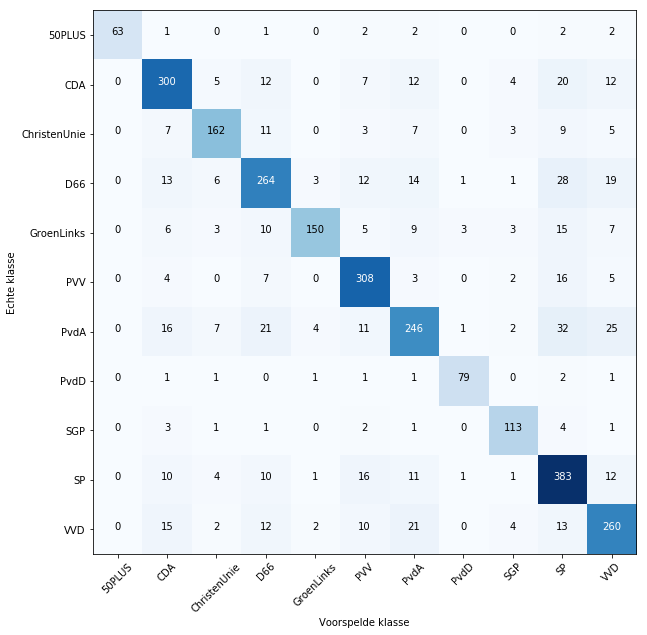

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,50plus,cda,de christenunie,d66,groenlinks,pvv,de pvda,lid ouwehand,sgp,sp,de vvd
1,het lid krol,het cda,christenunie,mijn fractie,lid van tongeren,de pvv,pvda,het lid ouwehand,de sgp,de sp,vvd
2,lid krol naar,cda fractie,lid dik,leden van veldhoven,lid voortman naar,nederland,de partij van,lid ouwehand naar,sgp fractie,sp fractie,de vvd fractie
3,lid krol,de cda fractie,het lid dik,van veldhoven,het lid voortman,islamitische,van de arbeid,ouwehand naar,de sgp fractie,de sp fractie,vvd fractie
4,krol naar mij,de cda,lid dik faber,veldhoven,lid voortman,miljard,de arbeid,ouwehand naar mij,de leden dijkgraaf,van gerven,de vvd is
5,krol naar,lid omtzigt naar,dik faber,lid van veldhoven,voortman,het lid graus,partij van de,ouwehand,leden dijkgraaf,gerven,vvd is
6,krol,lid omtzigt,faber,lid van meenen,tongeren,lid graus,partij van,dieren,leden van der,lid van gerven,voor de vvd
7,van 50plus,het lid omtzigt,leden voordewind,d66 wil,van tongeren,graus,arbeid,voor de dieren,mevrouw de voorzitter,smaling,wat de vvd
8,gepensioneerden,het cda is,de leden voordewind,d66 is,tongeren naar mij,lid graus naar,de partij,de dieren,mevrouw de,leijten naar mij,vvd vindt
9,ouderen,cda is,dik,de leden schouw,van tongeren naar,klever,pvda fractie,thieme,de leden bisschop,leijten naar,de vvd vindt


In [16]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="confusionmatrix",params= {'SGD__max_iter':3})
mostimportantwords(pipe, countdf, filename='MostImportantWords')

# What went wrong

In [ ]:
missclassdocs = df.loc[chain.from_iterable(indiceslist)]
np.mean([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
np.median([len(doc) for doc in missclassdocs.stemmed_text.apply(lambda x: x.split(" "))])
fig, ax = plt.subplots()
for a,l in [(missclassdocs.stemmed_text.apply(lambda x:len(x.split(" "))),'Verkeerd geclassificeerde documenten'), ((df.stemmed_text.apply(lambda x:len(x.split(" ")))),'Alle documenten')]:
    sns.distplot(a, kde=False, norm_hist=True, label=l, axlabel='Woorden per document')
plt.legend()
plt.savefig("Verslag/Tables/misclassifiedlengths.png")
plt.show()

In [ ]:
print(len(df[df['titel'].str.contains("Vragen van het lid")])/len(df))
print(len(missclassdocs[missclassdocs['titel'].str.contains("Vragen van het lid")])/len(missclassdocs))

# Without Names

In [17]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(df.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(df.surname.unique()) + "|Dijkstra|Van Dijk|Van Nieuwenhuizen|Baay|Berndsen|Jansen|Günal|Schut|Nijkerken|Buma|Venrooy|Mulder|De Vries|Berckmoes|Van Dijck|Pia")
temp = df.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
df['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
df['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ') for t in tokenizer.tokenize(x)]))
del temp

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:08<00:00, 73.67s/it]


              Precision  Recall  $F_1$ score Accuracy  Documenten
50PLUS             0.80    0.51         0.62        -          79
CDA                0.59    0.47         0.51        -         375
ChristenUnie       0.58    0.50         0.53        -         218
D66                0.52    0.55         0.52        -         374
GroenLinks         0.71    0.38         0.48        -         219
PVV                0.57    0.84         0.68        -         348
PvdA               0.47    0.51         0.49        -         355
PvdD               0.76    0.65         0.70        -          93
SGP                0.69    0.72         0.70        -         125
SP                 0.57    0.62         0.59        -         451
VVD                0.57    0.44         0.49        -         343
Totaal             0.58    0.56         0.56     0.56        2980


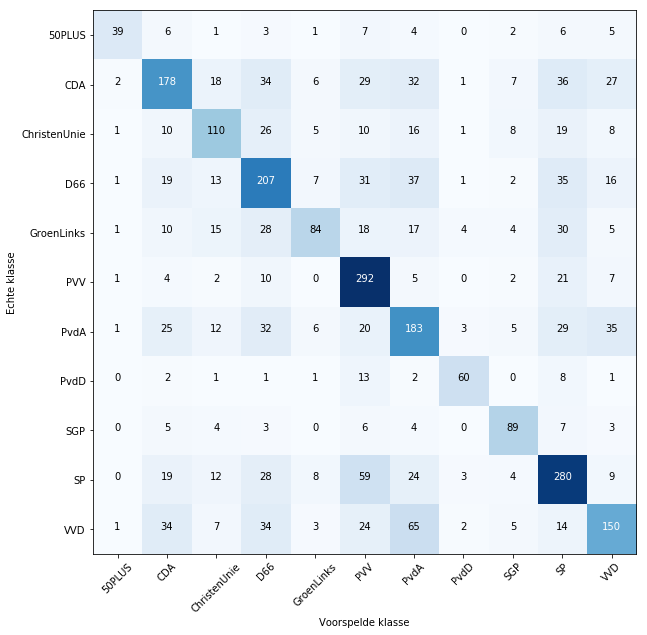

,50PLUS,CDA,ChristenUnie,D66,GroenLinks,PVV,PvdA,PvdD,SGP,SP,VVD
0,ouderen,PARTIJ fractie,zullen,mijn fractie,schone energie,islamitische,en,dieren,mevrouw de voorzitter,huurders,PARTIJ
1,gepensioneerden,inwoners,mensenhandel,mijn,belastingontwijking,nederland,circulaire economie,natuur,mevrouw de,zegt,volgens mij
2,koopkrachtontwikkeling,PARTIJ,vluchtelingen,het kabinet,schone,miljard,jongeren,bio,beantwoording,mening dat,aangegeven
3,oudere,regering,gezinnen,fractie,zou,brussel,circulaire,de bio,bewindslieden,van mening dat,aruba
4,plussers,de regering,inderdaad,natuurlijk,kamer hierover te,islam,kinderen,milieu,voor de beantwoording,bezuinigingen,PARTIJ fractie
5,50 plussers,fractie,elkaar,belangrijk,vluchtelingen,natuurlijk,daarbij,constaterende dat,punt,mensen,regelgeving
6,50,hier,turkije,kabinet,persoonsgebonden,al,wij,constaterende,de beantwoording,van mening,PARTIJ is
7,werkenden,echt,dementie,buitengewoon,ontwikkelingssamenwerking,de islam,vragen,bio industrie,zou,armoede,volgens
8,overwegende dat,wij,nu,vandaag,persoonsgebonden budget,asielzoekers,van mening,de bio industrie,vanuit,bestuurders,speelveld
9,overwegende,zorginstellingen,strijd tegen,minister,in elk geval,dit kabinet,de regering tevens,dierenwelzijn,nadrukkelijk,mening,uwv


In [18]:
pipe, indiceslist = traintest('Scores.xlsx', df, save="withoutnames",params= {'SGD__max_iter':3}, stemmed='stemmed_withoutnames', normal='normal_withoutnames')
mostimportantwords(pipe, countdf, filename='MostImportantWordsWithoutNames')

# Only Names

In [ ]:
partijnamen = list(df.party.unique()) + Party_synomyns
df["names"] = df.text.apply(lambda x: re.findall(partijnamen, x)+re.findall(kamerlidnamen, x))
df["names"] = df.names.apply(lambda x: ' '.join([y.replace(" ", "") for y in x]).lower())
df.head(5)

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df, save = "onlynames", params= {'vect__ngram_range':(1,1),'SGD__max_iter':3}, stemmed='names', normal='names')

In [ ]:
mostimportantwords(pipe, countdf, filename='onlynames')

# Confusion matrix analyse

In [ ]:
def traintest2(file, data, save=False,stemmed="stemmed_text",normal="normal_text"):
    train, test = data
    pipe, stem = getbestpipe(file)
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    cm = confusion_matrix(test.party, predicted)
    tot = len(predicted)
    ggg = defaultdict(int)
    mix = []
    regering = []
    oppositie = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[0]):
            if i!=j:
                a = (sum(cm[i,:])-cm[i,i]) * (sum(cm[j,:])/(tot-sum(cm[i,:])))
                ggg[(i,sum(cm[i,:]))]+=a
                if i in [6,10] and j in [6,10]:
                    regering.append(cm[i,j]-a)
                elif i in [0,1,2,3,4,5,7,8,9] and j in [0,1,2,3,4,5,7,8,9]:
                    oppositie.append(cm[i,j]-a)
                else:
                    mix.append(cm[i,j]-a)
    return pipe, oppositie, regering, mix, ggg

In [ ]:
o = []
m = []
r = []
g = {}
for i in tqdm(range(10)):
    pipe, oppositie, regering, mix, ggg=traintest2('Scores.xlsx', train_test_split(df, test_size=0.2), stemmed='stemmed_withoutnames', normal='normal_withoutnames')
    g ={**g, **ggg}
    o.append(oppositie)
    r.append(regering)
    m.append(mix)

In [ ]:
(keys,values) = zip(*g.items())
party, keys = zip(*keys)
keys = pd.Series(keys,name='fn + tp')
values = pd.Series(values,name='fp')
party = pd.Series(party,name="Partij").replace(dict(enumerate(sorted(df.party.unique()))))
q = sns.lmplot(x='fn + tp', y='fp', hue='Partij', data=pd.concat([keys, values, party], axis=1),fit_reg=False, palette=sns.color_palette("hls", 11))
ax = sns.regplot(keys, values, scatter=False, ax=q.axes[0, 0])
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Correlation.png') 
scipy.stats.pearsonr(keys,values)

In [ ]:
# Dit gebruiken
ax = sns.distplot(list(chain.from_iterable(o)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Oppositie.png') 
print("Mean:",np.mean(list(chain.from_iterable(o))))
print(scipy.stats.normaltest(list(chain.from_iterable(o))))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Regering.png') 
np.mean(list(chain.from_iterable(r)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Mix.png') 
np.mean(list(chain.from_iterable(m)))

In [ ]:
ax = sns.distplot(list(chain.from_iterable(m+o+r)),kde=False)
fig = ax.get_figure()
fig.savefig('Verslag/Tables/Totaal.png')
print(np.mean(list(chain.from_iterable(m+o+r))))
print(scipy.stats.normaltest(list(chain.from_iterable(m+o+r))))

In [ ]:
scipy.stats.normaltest(list(chain.from_iterable(m+o+r)))

# Woorden Balkenende 4

In [21]:
# Importing data
dfb4 = importdata("HandelingenBalkenende4.csv")
dfb4['stemmed_text'] = dfb4.text.apply(lambda x: ' '.join([stemmer.stem(t) for t in tokenizer.tokenize(x)]))
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) < math.exp(fit[0]+2*fit[1])]
dfb4 = dfb4.loc[dfb4.stemmed_text.apply(lambda x: len(x.split(' '))) > math.exp(fit[0]-2*fit[1])]

In [22]:
# Creates a dataframe with counts of dataset per party
countdfb4 = dfb4.party.value_counts().sort_index()
countdfb4

CDA             1039
ChristenUnie     561
D66              518
GroenLinks       760
PVV              971
PvdA             903
PvdD             165
SGP              507
SP              1222
VVD             1041
Name: party, dtype: int64

In [23]:
Party_synomyns = ["Partij van de Arbeid","Socialistische Partij","Partij voor de Dieren","Volkspartij voor Vrijheid en Democratie","Partij voor de Vrijheid"]
partijnamen = list(dfb4.party.unique()) + Party_synomyns
partijnamen += ["[Hh]et "+ x for x in partijnamen] + ["[Dd]e "+ x for x in partijnamen]
partijnamen = re.compile('|'.join(partijnamen))
kamerlidnamen = re.compile('|'.join(dfb4.surname.unique())+"|Kortenhorst|Wiegman|De Roos|Schreijer|Willemse|Snijder|Van Vroonhoven|Dezentjé Hamming|Blanksma|Buma|De Pater|Ortega|Madsen")
temp = dfb4.text.apply(lambda x: re.sub(kamerlidnamen,"xxxxx",re.sub(partijnamen,"yyyyy",x)).lower())
dfb4['stemmed_withoutnames'] = temp.apply(lambda x: ' '.join([stemmer.stem(t).replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))
dfb4['normal_withoutnames'] = temp.apply(lambda x: ' '.join([t.replace("xxxxx",'KAMERLID').replace("yyyyy", 'PARTIJ').replace("KAMERLIDman", "timmerman") for t in tokenizer.tokenize(x)]))

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', dfb4, normal = 'normal_withoutnames', stemmed='stemmed_withoutnames',params= {'SGD__max_iter':100})

In [ ]:
mostimportantwords(pipe, countdfb4, 'WoordenBalkenende4')

# Vergelijken

In [36]:
def traintest5(file, data, save=False, stemmed="stemmed_text",normal="normal_text"):
    pipe, stem = getbestpipe(file)
    train, test = data
    text = stemmed if stem else normal
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    print(report)
    cnf_matrix = confusion_matrix(test.party, predicted)
    plt.figure(figsize=(10, 10))
    plot_confusion_matrix(cnf_matrix.astype(int), \
                      classes=sorted(list(train.party.unique())), \
                      title='Confusion matrix best estimator')
    if save:
        plt.savefig("Verslag/Tables/%s.png" %save)
        with open("Verslag/Tables/%s.tex" %save, "w") as f:
            f.write(report.to_latex())
    return pipe

['              precision    recall  f1-score   support', '', '         CDA       0.28      0.43      0.34      1039', 'ChristenUnie       0.37      0.22      0.28       561', '         D66       0.16      0.28      0.20       518', '  GroenLinks       0.31      0.04      0.07       760', '         PVV       0.50      0.60      0.55       971', '        PvdA       0.29      0.27      0.28       903', '        PvdD       0.64      0.45      0.53       165', '         SGP       0.56      0.49      0.52       507', '          SP       0.41      0.53      0.46      1222', '         VVD       0.18      0.10      0.13      1041', '', ' avg / total       0.34      0.35      0.33      7687', '']
              Precision  Recall  $F_1$ score  Accuracy  Documenten
CDA                0.28    0.43         0.34       NaN        1039
ChristenUnie       0.37    0.22         0.28       NaN         561
D66                0.16    0.28         0.20       NaN         518
GroenLinks         0.31    0.04    

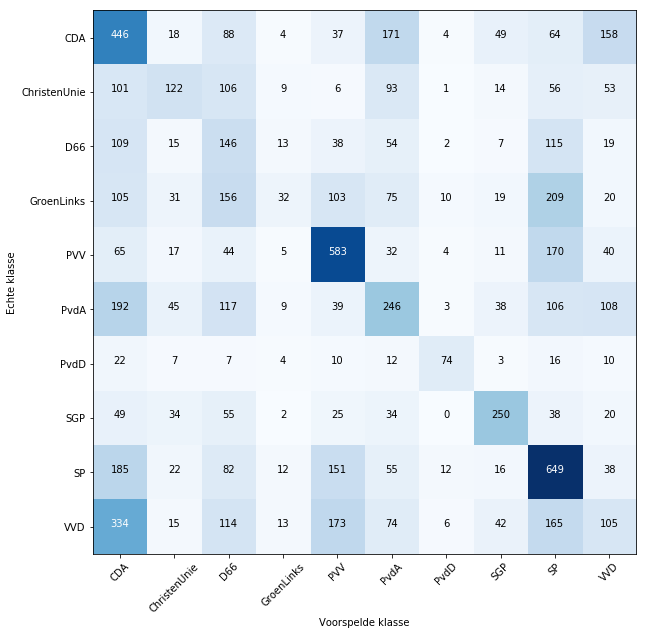

In [37]:
pipe = traintest5('Scores.xlsx', (df[df.party != '50PLUS'],dfb4), save="RutToBal", stemmed="stemmed_withoutnames", normal="normal_withoutnames")

              Precision  Recall  F1 score  Accuracy  Documenten
CDA                0.19    0.48      0.27       NaN        1901
ChristenUnie       0.25    0.09      0.13       NaN        1068
D66                0.26    0.10      0.14       NaN        1889
GroenLinks         0.16    0.09      0.11       NaN        1068
PVV                0.48    0.55      0.51       NaN        1700
PvdA               0.26    0.21      0.23       NaN        1821
PvdD               0.67    0.24      0.35       NaN         432
SGP                0.51    0.39      0.44       NaN         655
SP                 0.38    0.50      0.43       NaN        2284
VVD                0.19    0.11      0.14       NaN        1694
Totaal             0.30    0.30      0.28  0.296444       14512


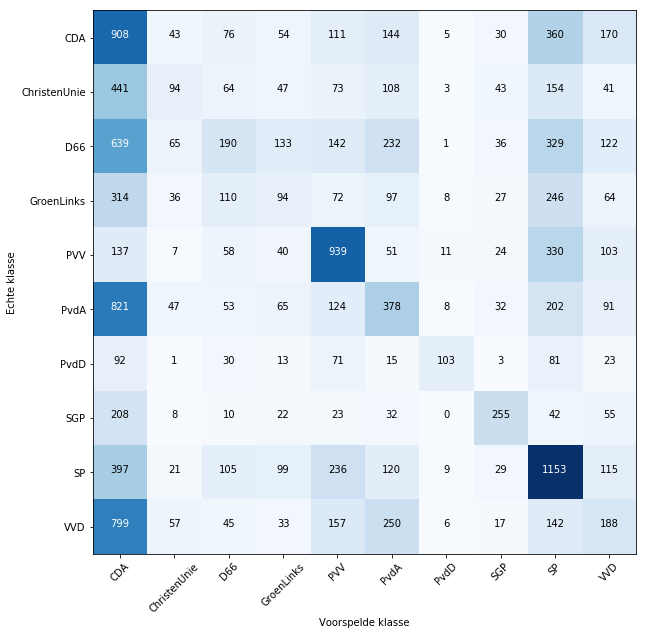

In [44]:
pipe = traintest5('Scores.xlsx', (dfb4,df[df.party != '50PLUS']), save="BalToRut", stemmed="stemmed_withoutnames", normal="normal_withoutnames")

In [ ]:
woordenBalk = pd.read_excel('WoordenBalkenende4.xlsx', index_col=0)
woordenRut = pd.read_excel('MostImportantWordsWithoutNames.xlsx', index_col=0)
commondict = defaultdict(dict)
for partyB in ["PvdA", "ChristenUnie", "CDA"]:
    for partyR in ["VVD", "PvdA"]:
        commondict[partyB][partyR] = [x for x in set(woordenBalk[partyB])&set(woordenRut[partyR]) - set(woordenBalk[partyR]) - set(woordenRut[partyB])]
commondict

In [ ]:
oppositiewoorden = woordenBalk.drop(["PvdA", "ChristenUnie", "CDA"], axis=1).values.flatten()
pointlesswords = ["in","men","de"]
for partyB in ["PvdA","CDA", "ChristenUnie"]:
    for partyR in ["PvdA", "ChristenUnie", "CDA"]:
        if partyR!=partyB:
            for word in woordenBalk[partyR]:
                for word2 in woordenBalk[partyB]:
                    if word in word2 and word not in pointlesswords and word2 not in pointlesswords and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

In [ ]:
oppositiewoorden = woordenRut.drop(['VVD', 'PvdA'], axis=1).values.flatten()
for partyB in ["PvdA", "VVD"]:
    for partyR in ["VVD", "PvdA"]:
        if partyR!=partyB:
            for word in woordenRut[partyR]:
                for word2 in woordenRut[partyB]:
                    if word in word2 and word not in ["en","in","men"] and word2 not in ["en","in","men"] and word not in oppositiewoorden and word2 not in oppositiewoorden:
                        print(partyB, "->",partyR,":",word,",", word2)

# Links / Rechts vergelijken

In [ ]:
# df['Kieskompas'] = df['party'].map({'CDA': 'Rechts', 'ChristenUnie': 'Rechts', 'D66':'Rechts', 'SGP':'Rechts', 'VVD':'Rechts', 'SP':'Links','PvdD':'Links','GroenLinks':'Links','PvdA':'Links','50PLUS':'Links'})
# pipe, predicted = traintest('Scores.xlsx', datasplitter(df.dropna(), 0.8))

In [ ]:
# pipe, _ = getbestpipe('Scores.xlsx')
# df_train = df.dropna().sample(frac=0.8)
# df_test_index = list(set(df.index.tolist()) - set(df_train.index.tolist()))
# df_test = df.dropna()[df.dropna().index.isin(df_test_index)]
# pipe.fit(df_train.withoutnames, df_train.Kieskompas)
# predicted = pipe.predict(df_test.withoutnames)
# print(classification_report(df_test.Kieskompas, predicted))

# Taalgebruik van sprekers

In [ ]:
def traintest3(pipe, text, data, save=False):
    trainsprekers, testsprekers = train_test_split(data.surname.unique(), test_size=0.2)
    train = data[data['surname'].isin(trainsprekers)]
    test = data[data['surname'].isin(testsprekers)]
     
    pipe.fit(train[text], train.party)
    predicted = pipe.predict(test[text])
    report = classification_report_csv(test.party, predicted)
    accuracy = accuracy_score(test.party, predicted)
    cnf_matrix = confusion_matrix(test.party, predicted)
    indices = np.where(test.party != predicted)
    indices = test.iloc[indices].index.values
    return pipe, cnf_matrix, report, accuracy, indices
    

In [ ]:
pipe, indiceslist = traintest('Scores.xlsx', df ,save="taalgebruik", stemmed='stemmed_withoutnames', normal='normal_withoutnames',params= {'SGD__max_iter':100})
mostimportantwords(pipe, countdf, 'taalgebruik')